In [29]:
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
from shutil import copyfile
from collections import defaultdict
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape, LSTM, Bidirectional, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [30]:
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    dataset_dirs = {
        "/content/drive/MyDrive/audio_representations/SAVEE/spectrograms": 1,
        "/content/drive/MyDrive/audio_representations/TESS/spectrograms": 0.4,
        "/content/drive/MyDrive/audio_representations/RAVDESS/spectrograms": 0.7
    }
else :
    dataset_dirs = {
        "../audio_representations/audio_representations_savee/spectrograms/": 1,
        "../audio_representations/audio_representations_Tess/spectrograms/": 0.4,
        "../audio_representations/audio_representations_ravdess/spectrograms/": 0.7
    }

In [31]:
images, labels = [], []

# Load images and extract labels
for dataset_dir, sampling_rate in dataset_dirs.items():
    all_files = [f for f in os.listdir(dataset_dir) if f.endswith(".png")]
    sampled_files = np.random.choice(all_files, size=int(len(all_files) * sampling_rate), replace=False)

    for file_name in sampled_files:
        file_path = os.path.join(dataset_dir, file_name)
        img = Image.open(file_path).convert("RGB").resize((256, 256))
        images.append(np.array(img))

        # Extract label from filename (e.g., third part of 'emotion-xx-yy.png')
        parts = file_name.split("-")
        if len(parts) >= 3:
            label_raw = int(parts[2]) - 1  # Convert to 0-based index
        else:
            print(f"Skipping {file_name}: Incorrect format.")
            continue
        labels.append(label_raw)

# Convert to NumPy arrays
images = np.array(images) / 255.0  # Normalize pixel values to [0, 1]
labels = np.array(labels)
num_classes = len(np.unique(labels))  # Number of emotion classes

# One-hot encode the labels
labels_one_hot = to_categorical(labels, num_classes=num_classes)

# Split dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels_one_hot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (1628, 256, 256, 3), (1628, 8)
Validation set: (349, 256, 256, 3), (349, 8)
Test set: (350, 256, 256, 3), (350, 8)


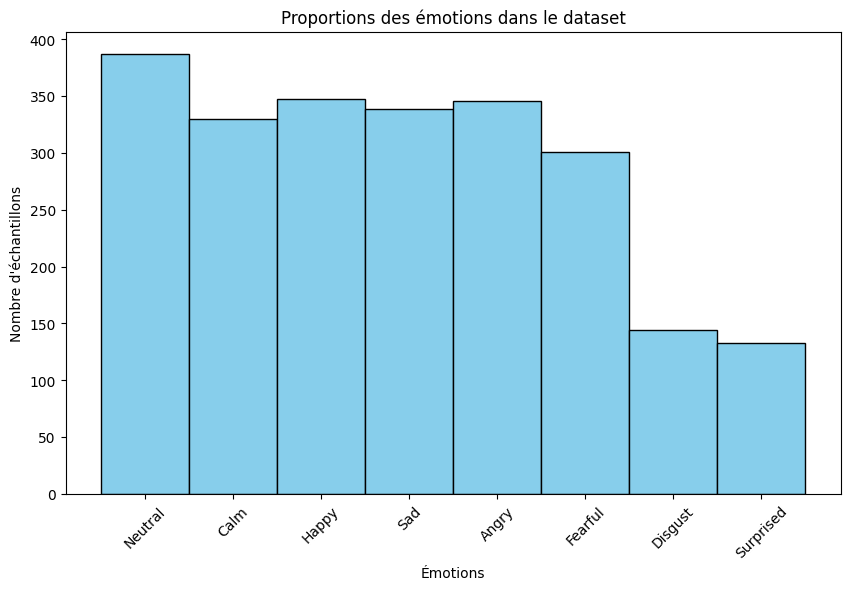

In [32]:

# Dictionnaire pour correspondre les codes aux émotions
emotion_map = {
    1: 'Neutral',
    2: 'Calm',
    3: 'Happy',
    4: 'Sad',
    5: 'Angry',
    6: 'Fearful',
    7: 'Disgust',
    8: 'Surprised'
}

# Exemple d'étiquettes (label_raw), où chaque valeur représente un code émotionnel (basé sur 0)
# Par exemple, 0 = 'Neutral', 1 = 'Calm', etc.
# labels = np.array([0, 1, 2, 3, 4, 5, 6, 7])  # Exemple d'étiquettes

# Utiliser les labels pour mapper les codes aux émotions
emotion_labels = [emotion_map[label + 1] for label in labels]  # +1 car les étiquettes sont basées sur 0

# Créer un histogramme des proportions de chaque émotion
plt.figure(figsize=(10, 6))
plt.hist(emotion_labels, bins=np.arange(len(emotion_map) + 1) - 0.5, edgecolor='black', color='skyblue')
plt.xticks(np.arange(len(emotion_map)), list(emotion_map.values()), rotation=45)
plt.title('Proportions des émotions dans le dataset')
plt.xlabel('Émotions')
plt.ylabel('Nombre d\'échantillons')
plt.show()

In [34]:
def create_cnn_blstm_attention_model(input_shape, num_classes):
    # Définir l'entrée
    input_layer = Input(shape=input_shape)

    # Partie CNN
    x = Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Applatir la sortie du CNN
    x = Flatten()(x)

    # Reshape pour LSTM (pour créer une séquence de features)
    x = Reshape((1, -1))(x)  # reshape pour (batch_size, time_steps, features)

    # Partie BLSTM
    x = Bidirectional(LSTM(64, return_sequences=True))(x)

    # Ajouter la couche d'attention (Attention layer attend une liste d'entrées)
    attention_output = Attention()([x, x])  # Ici, on applique l'attention sur la sortie de LSTM

    # Ajouter un fully connected layer
    x = Flatten()(attention_output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)  # Dropout pour éviter le surapprentissage

    # Couche de sortie
    output_layer = Dense(num_classes, activation='softmax')(x)

    # Créer le modèle
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compiler le modèle
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Définir l'entrée et les classes
input_shape = (256, 256, 3)  # Taille des images (256x256, 3 canaux RGB)
num_classes = 8  # Exemple de 7 classes d'émotions

# Créer le modèle
model = create_cnn_blstm_attention_model(input_shape, num_classes)

# Résumé du modèle
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 254, 254,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 127, 127,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 125, 125,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 62, 62,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 60, 60,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 30, 30,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 115200)    │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 115200) │          0 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 1, 128)    │ 59,015,680 │ reshape[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 1, 128)    │          0 │ bidirectional[0]… │
│ (Attention)         │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 128)       │          0 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 8)         │      1,032 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 59,126,472 (225.55 MB)

 Trainable params: 59,126,472 (225.55 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val)
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Loss on the test set : {test_loss}")
print(f"Accuracy on the test set : {test_accuracy}")

Epoch 1/20


c:\Users\aubin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


51/51 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.2616 - loss: 1.8869 - val_accuracy: 0.6819 - val_loss: 0.9796
Epoch 2/20
48/51 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6067 - loss: 1.1050

KeyboardInterrupt: 

In [6]:
save_path = '/content/drive/MyDrive/models/cnn_blstm_attention_ravdess_spectrograms'

model.save(save_path + "/weights.h5")

In [7]:
plt.figure(figsize=(6, 5))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Evolution")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig(os.path.join(save_path, "loss_curve.png"))
plt.close()

plt.figure(figsize=(6, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Evolution")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(os.path.join(save_path, "accuracy_curve.png"))
plt.close()


In [8]:
emotion_labels = [
    "Neutral", "Calm", "Happy", "Sad", "Angry",
    "Fearful", "Disgust", "Surprised"
]

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix,
    display_labels=emotion_labels
)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix CNN-BLSTM with attention Spectrograms")
conf_matrix_path = os.path.join(save_path, "confusion_matrix.png")
plt.savefig(conf_matrix_path)
plt.close()


3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step 

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
